In [3]:
from contraction import (
    normalize_key, contract_degree2_chains, clean_ham_cond, full_contraction_ham,
)
from standard import (
    compute_laplacian, compute_laplacian_eigenpairs, normalize_rows, plot_eigengap, find_candidate_ks,
    perturb_laplacian, check_candidate_stability, select_best_candidate, spectral_k_pipeline,
    laplacian_clustering_pipeline,
)
from signless import (
    compute_signless_laplacian, signless_laplacian_clustering_pipeline,
)
from dual_clus import (
    compute_edge_agreement_weights, build_layout, draw_dual_colored_graph, compute_alpha_beta,
)
from vis import (
    get_color_vector, cluster_aware_layout, draw_graph_with_labels,
)


import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from test_data import generate_random_hamiltonian_graphs
test_graphs = generate_random_hamiltonian_graphs(n=120, num_graphs=2, extra_edge_prob=0.01)


standard lap clustering pipeline on graph 1
candidate ks: [{'k': np.int64(9), 'eigengap': np.float64(0.022257777979955345), 'silhouette': 0.2669201095554337, 'score': np.float64(0.0031332029463139494), 'index': np.int64(8), 'threshold': np.float64(0.020426630177980073), 'type': 'first', 'dim': np.int64(19), 'stability': 1.0, 'score_stable': np.float64(0.0031332029463139494)}, {'k': np.int64(31), 'eigengap': np.float64(0.04034947838114056), 'silhouette': 0.2991418952460601, 'score': np.float64(0.0016909579940730603), 'index': np.int64(30), 'threshold': np.float64(0.020426630177980073), 'type': 'highest', 'dim': 119, 'stability': 1.0, 'score_stable': np.float64(0.0016909579940730603)}, {'k': np.int64(22), 'eigengap': np.float64(0.0253096076596937), 'silhouette': 0.27640685365432316, 'score': np.float64(0.0014684253036424998), 'index': np.int64(21), 'threshold': np.float64(0.018891525503084695), 'type': 'highest', 'dim': np.int64(31), 'stability': 1.0, 'score_stable': np.float64(0.001468

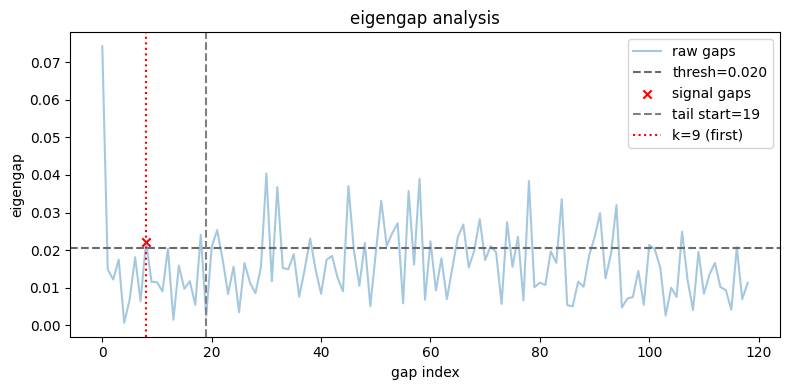

KeyboardInterrupt: 

In [ ]:
lap_results = []
for idx, d in enumerate(test_graphs):
    G = d['graph']
    print(f"\nstandard lap clustering pipeline on graph {idx+1}")
    res = laplacian_clustering_pipeline(G, plot=True)
    lap_results.append(res)
    labels =res['labels']
    if labels:
        draw_graph_with_labels(G, labels)


signless laplacian clustering on graph 1 ---


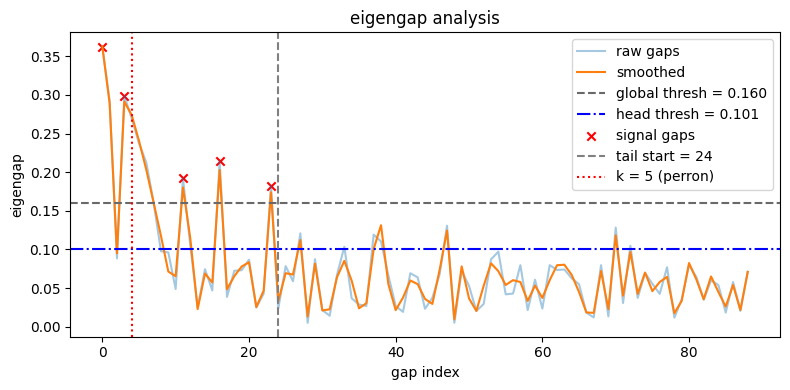

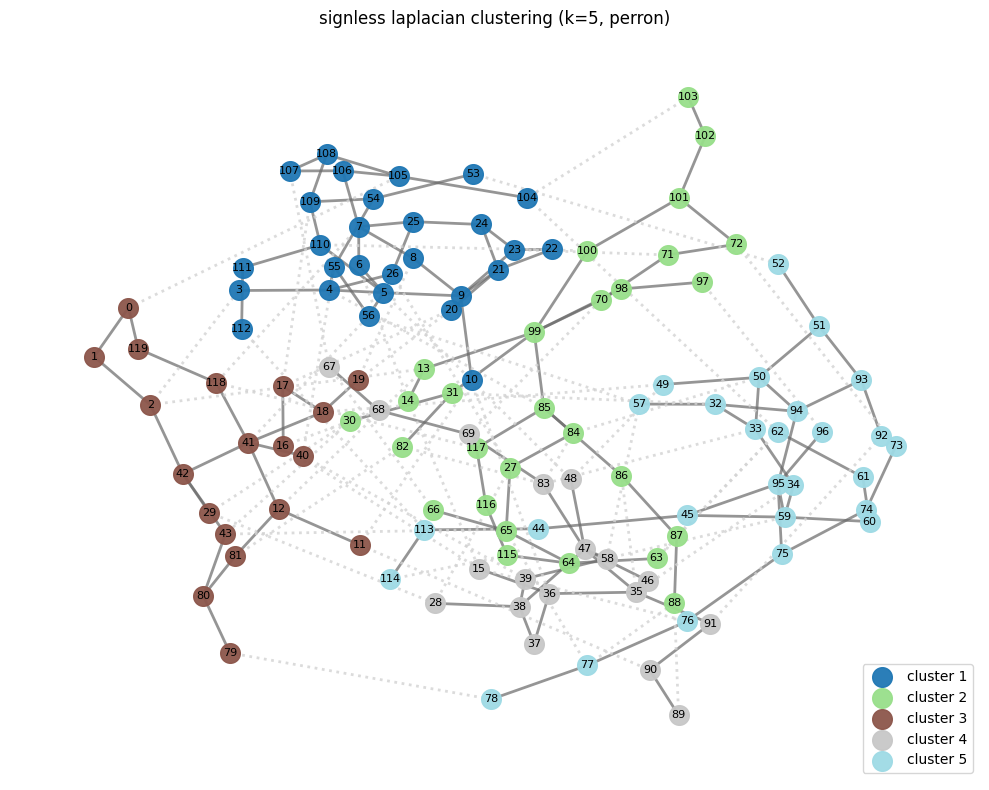


signless laplacian clustering on graph 2 ---


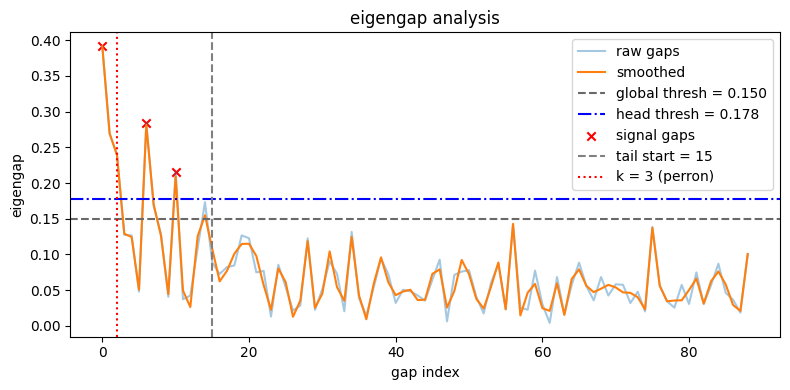

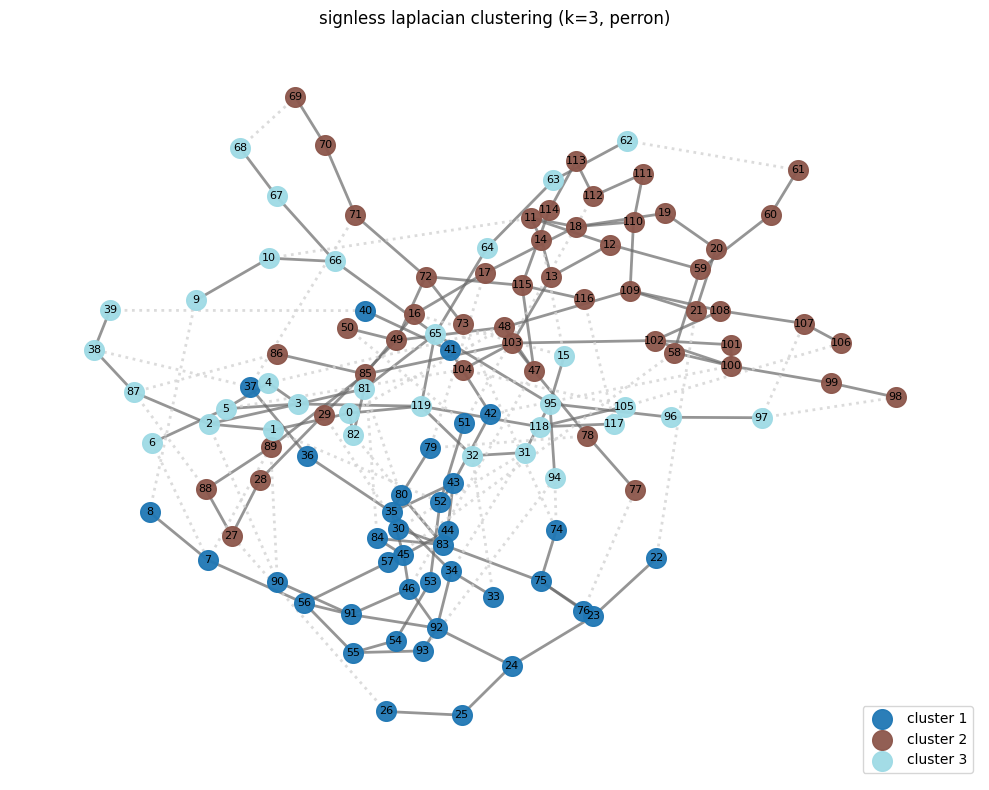

In [ ]:
# signless Laplacian pipeline test
signless_results = []
for idx, d in enumerate(test_graphs):
    G = d['graph']
    print(f"\nsignless laplacian clustering on graph {idx+1} ---")
    res = signless_laplacian_clustering_pipeline(G, plot=True)
    signless_results.append(res)


chain contraction on graph 0
contracted chains: [(0, 2), (2, 4), (21, 23), (36, 38), (45, 47), (51, 54), (60, 62), (62, 64), (65, 67), (72, 74), (77, 80), (88, 90), (91, 93), (95, 99), (101, 104), (110, 113), (113, 115), (115, 117), (0, 118), (4, 118), (43, 45), (60, 65), (86, 88), (101, 105), (110, 117)]


/var/folders/8p/_chtsr094z32zkn82wyl40600000gn/T/ipykernel_19219/1681850525.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(cluster_ids))(range(len(cluster_ids)))


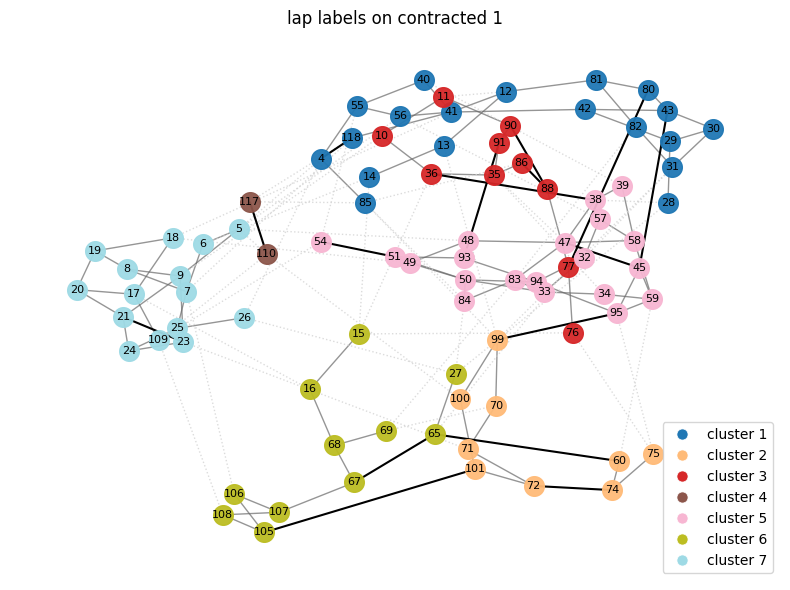

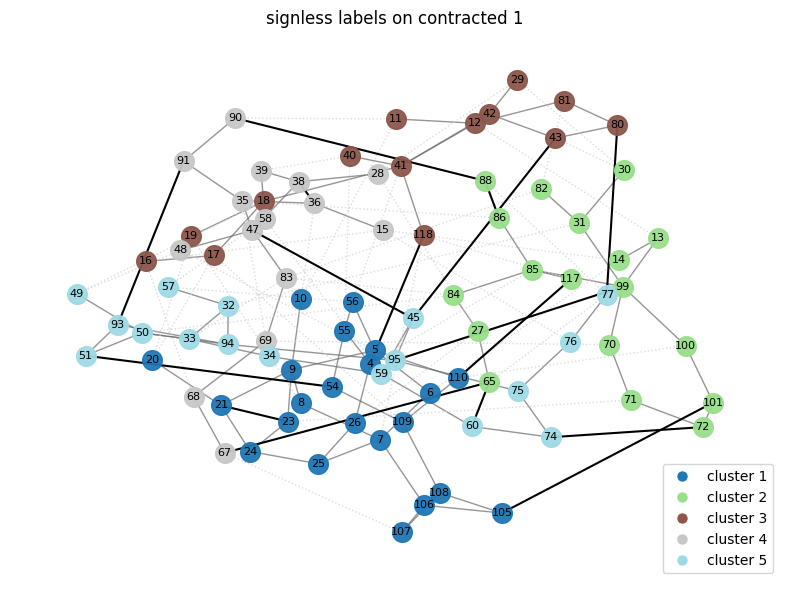


chain contraction on graph 1
contracted chains: [(5, 7), (7, 10), (18, 21), (21, 23), (24, 27), (27, 29), (32, 34), (35, 37), (38, 42), (43, 45), (49, 51), (52, 55), (56, 58), (59, 65), (66, 71), (72, 74), (75, 78), (85, 87), (95, 97), (97, 100), (100, 102), (105, 107), (110, 112), (112, 115), (115, 118), (5, 10), (18, 23), (24, 29), (38, 43), (49, 52), (56, 59), (87, 89), (95, 102), (105, 108), (110, 118)]


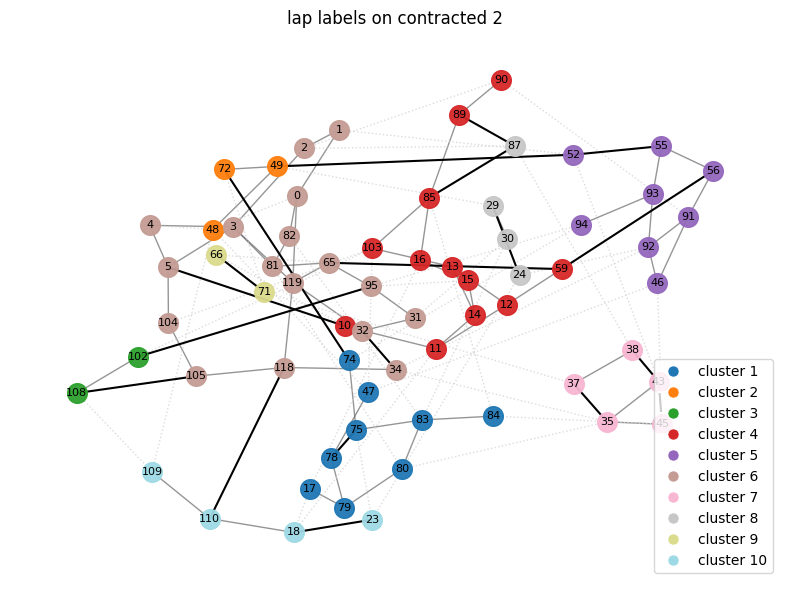

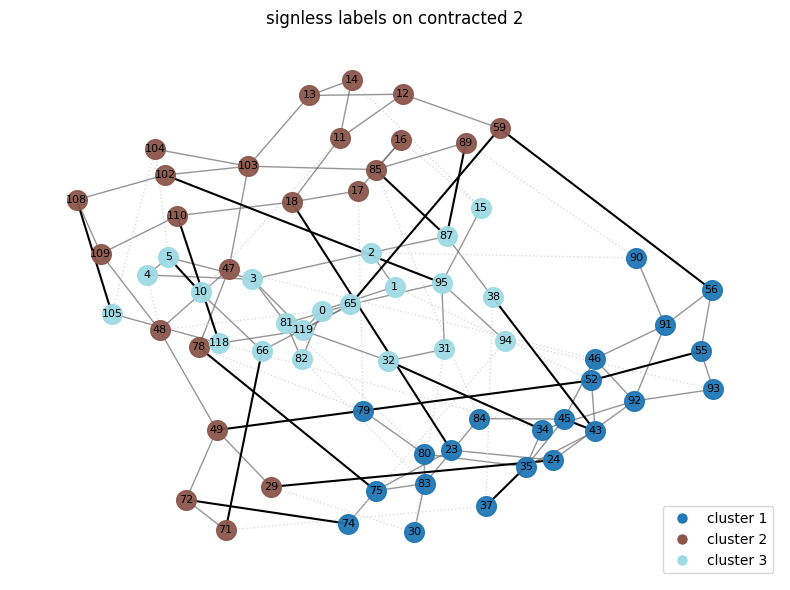

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from matplotlib.lines import Line2D

def draw_clusters_with_shortcuts(
    G, labels, shortcut_edges=None, memberships=None, pos=None, title=None
):
    # draw graph with clusters; shortcut edges in black; ignore nodes without labels
    shortcut_edges = set() if shortcut_edges is None else {tuple(sorted(e)) for e in shortcut_edges}
    labeled_nodes = set(labels)
    H = G.subgraph(labeled_nodes)
    
    # compute layout if needed
    if pos is None:
        if memberships is not None:
            pos = cluster_aware_layout(H, memberships=memberships, scale=1.0, weight_factor=1, seed=42)
        else:
            pos = cluster_aware_layout(H, labels=labels, scale=1.0, weight_factor=1, seed=42)
    
    # node colors by cluster
    cluster_ids = sorted(set(labels[n] for n in H.nodes()))
    colors = cm.get_cmap('tab20', len(cluster_ids))(range(len(cluster_ids)))
    color_map = {cid: colors[i] for i, cid in enumerate(cluster_ids)}
    
    plt.figure(figsize=(8, 6))
    for cid in cluster_ids:
        nodes = [n for n in H.nodes() if labels[n] == cid]
        nx.draw_networkx_nodes(H, pos, nodelist=nodes, node_color=[color_map[cid]],
            label=f'cluster {cid+1}', node_size=200, alpha=0.95)
    
    # classify edges
    intra, inter, shortcut = [], [], []
    for u, v in H.edges():
        e = tuple(sorted((u, v)))
        if e in shortcut_edges:
            shortcut.append((u, v))
        elif labels[u] == labels[v]:
            intra.append((u, v))
        else:
            inter.append((u, v))
    if intra:
        nx.draw_networkx_edges(H, pos, edgelist=intra, edge_color="dimgray", style="solid", alpha=0.7, width=1)
    if inter:
        nx.draw_networkx_edges(H, pos, edgelist=inter, edge_color="lightgray", style="dotted", alpha=0.8, width=1)
    if shortcut:
        nx.draw_networkx_edges(H, pos, edgelist=shortcut, edge_color="black", style="solid", alpha=1.0, width=1.5)
    
    nx.draw_networkx_labels(H, pos, font_size=8, font_color="black")
    plt.title(title or "clustered graph")
    plt.axis('off')
    handles = [
    Line2D([0], [0], marker='o', color='w', label=f'cluster {cid+1}',
           markerfacecolor=color_map[cid], markersize=8, markeredgewidth=0.5)
    for cid in cluster_ids
    ]
    plt.legend(handles=handles, loc='lower right')
    plt.tight_layout()
    plt.show()


# contraction test
contractions = []
for idx, d in enumerate(test_graphs):
    G = d['graph']
    Gc, all_chains = full_contraction_ham(G)
    print(f"\nchain contraction on graph {idx}")
    print(f"contracted chains: {all_chains}")
    labels = lap_results[idx]['labels']
    draw_clusters_with_shortcuts(Gc, labels, shortcut_edges=all_chains, title=f"lap labels on contracted {idx+1}")
    signless_labels = signless_results[idx]['labels']
    draw_clusters_with_shortcuts(Gc, signless_labels, shortcut_edges=all_chains, title=f"signless labels on contracted {idx+1}")

    res = {"contracted_graph":Gc, "all_chains":all_chains}
    contractions.append(res)

candidate ks: [{'k': np.int64(29), 'eigengap': np.float64(0.06430576794083787), 'silhouette': 0.19491490249751292, 'score': -inf, 'index': np.int64(28), 'threshold': np.float64(0.02691058059398568), 'type': 'highest', 'dim': 85, 'stability': 1.0, 'score_stable': -inf}, {'k': np.int64(6), 'eigengap': np.float64(0.029887941382721217), 'silhouette': 0.33591024007643017, 'score': np.float64(0.006654601157996896), 'index': np.int64(5), 'threshold': np.float64(0.02691058059398568), 'type': 'first', 'dim': 85, 'stability': 1.0, 'score_stable': np.float64(0.006654601157996896)}, {'k': np.int64(11), 'eigengap': np.float64(0.03237754704526008), 'silhouette': 0.26840885005032844, 'score': np.float64(0.0037334515650117037), 'index': np.int64(10), 'threshold': np.float64(0.03104894570322208), 'type': 'first', 'dim': np.int64(14), 'stability': 1.0, 'score_stable': np.float64(0.0037334515650117037)}, {'k': np.int64(14), 'eigengap': np.float64(0.04300682331156869), 'silhouette': 0.23711176530182917, '

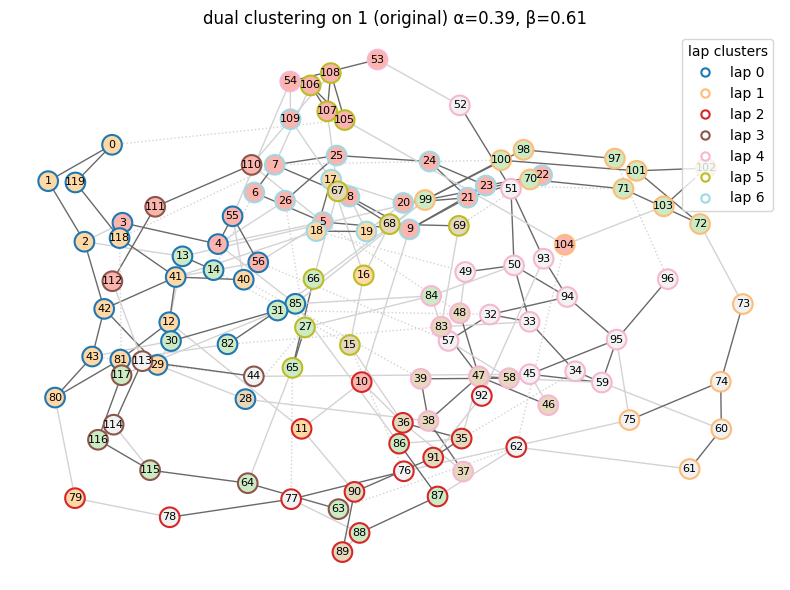

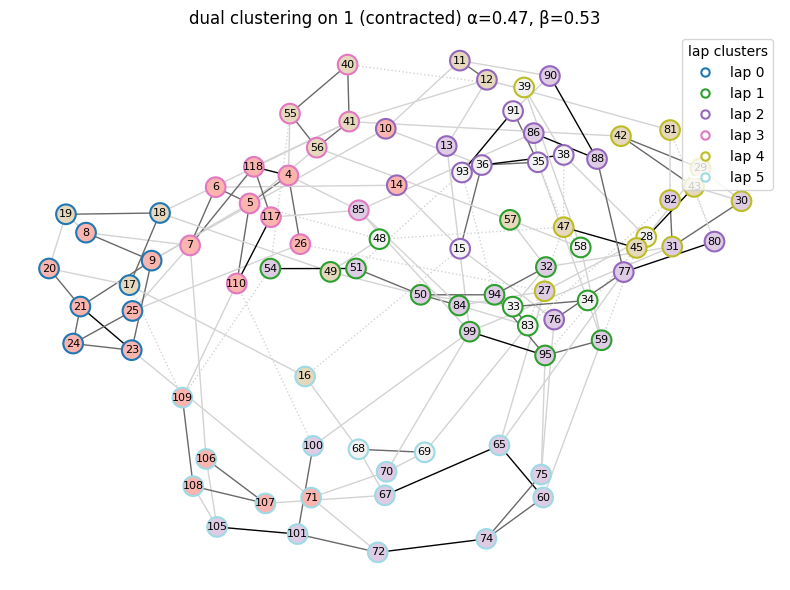

candidate ks: [{'k': np.int64(9), 'eigengap': np.float64(0.04147497321137705), 'silhouette': 0.2679834064724118, 'score': np.float64(0.0058432864239904335), 'index': np.int64(8), 'threshold': np.float64(0.03963339489612529), 'type': 'first', 'dim': np.int64(12), 'stability': 1.0, 'score_stable': np.float64(0.0058432864239904335)}, {'k': np.int64(56), 'eigengap': np.float64(0.06051643943191398), 'silhouette': 0.003318482440805511, 'score': -inf, 'index': np.int64(55), 'threshold': np.float64(0.03963339489612529), 'type': 'highest', 'dim': 65, 'stability': 1.0, 'score_stable': -inf}, {'k': np.int64(12), 'eigengap': np.float64(0.05846779050174883), 'silhouette': 0.2403407587180817, 'score': np.float64(0.006043331969292416), 'index': np.int64(11), 'threshold': np.float64(0.040965739824666024), 'type': 'highest', 'dim': np.int64(56), 'stability': 1.0, 'score_stable': np.float64(0.006043331969292416)}]
found k=12


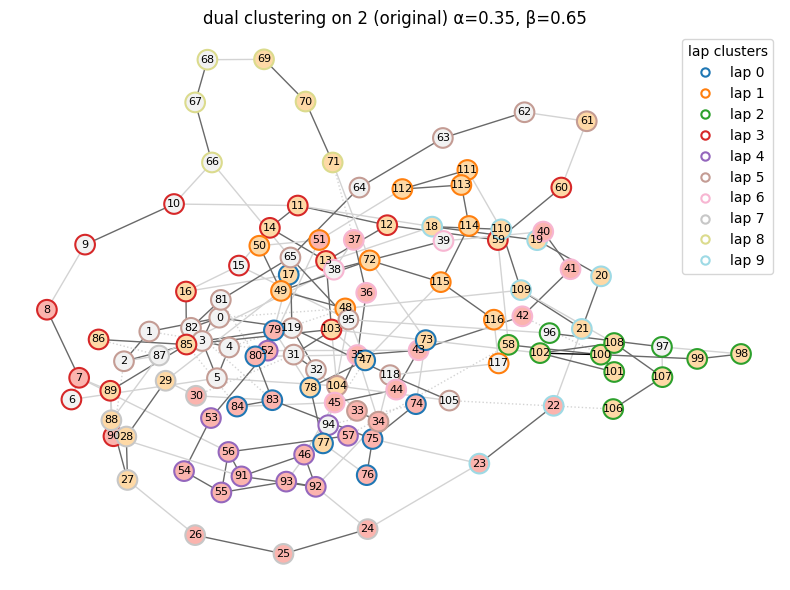

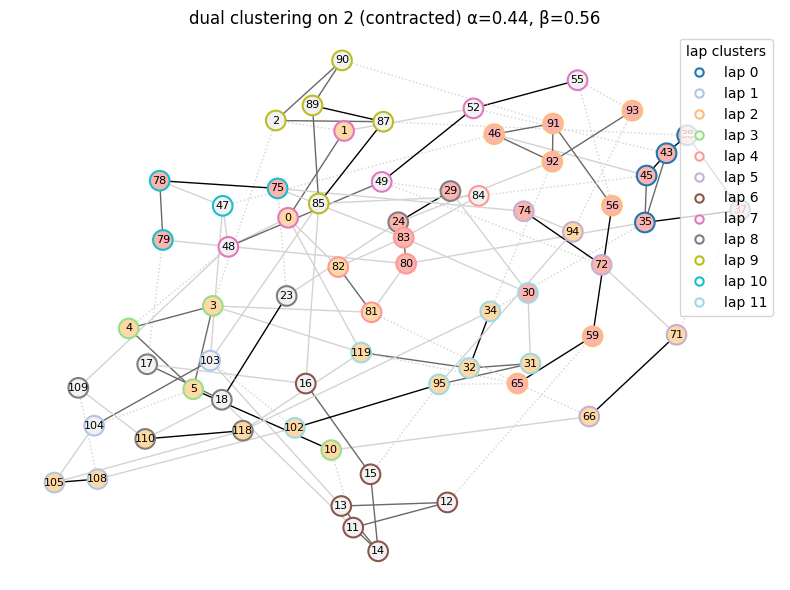

In [ ]:
all_data = []
for idx, d in enumerate(test_graphs):
    data= {}
    G = d['graph']
    Gc = contractions[idx]['contracted_graph']
    all_chains = contractions[idx]['all_chains']
    lap_orig= lap_results[idx]['labels']
    sig_orig = signless_results[idx]['labels']

    lap_contr = laplacian_clustering_pipeline(Gc, contracted_edges=all_chains, plot=False)
    sig_contr = signless_laplacian_clustering_pipeline(Gc, contracted_edges=all_chains, plot=False)
    a_orig, b_orig = compute_alpha_beta(lap_results[idx]['silhouette'],signless_results[idx]['silhouette'])
    a_contr, b_contr = compute_alpha_beta(lap_contr['silhouette'], sig_contr['silhouette'])

    draw_dual_colored_graph(
    G, lap_results[idx], signless_results[idx], alpha=a_orig, beta=b_orig, shortcuts=all_chains, title=f"dual clustering on {idx+1} (original) α={a_orig:.2f}, β={b_orig:.2f}"
)
    draw_dual_colored_graph(
        Gc, lap_contr, sig_contr, alpha=a_contr, beta=b_contr, shortcuts=all_chains, title=f"dual clustering on {idx+1} (contracted) α={a_contr:.2f}, β={b_contr:.2f}"
    )

    data["graph"] = G
    data["contracted_graph"] = Gc
    data["all_chains"] = all_chains
    data["lap_results"] = lap_results[idx]
    data["sig_results"] = signless_results[idx]
    data["lap_contr_results"] = lap_contr
    data["sig_contr_results"] = sig_contr
    data["a_orig"] = a_orig
    data["b_orig"] = b_orig
    data["a_contr"] = a_contr
    data["b_contr"] = b_contr
    all_data.append(data)